<a href="https://colab.research.google.com/github/timcsmith/MIS536-Public/blob/master/Notebooks/Class05_KNN_with_CONFUSION_MATRIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Bank k-NN model with Confusion Matrix


In [1]:
# Import required packages 
import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix # <- this is new
from sklearn.metrics import classification_report

#### Load data, clean, split and normalize data

In [2]:
# Load the data direct from GitHub
bank_df = pd.read_csv('https://github.com/timcsmith/MIS536-Public/raw/master/Data/UniversalBank.csv')

# strip any trailing/leading whitespace and transform any remaining whitespce to underscore
bank_df.columns = [s.strip().replace(' ','_') for s in bank_df.columns] # list comprehension, all columns

# drop ID and ZIP from data
bank_df = bank_df.drop(columns=['ID', 'ZIP_Code'])

# translate any categorical variables into dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=False)

# split the data into validation and training set
train_df, validation_df = train_test_split(bank_df, test_size=0.4, random_state=1)

# to reduce repetition in later code, let's create variables to represent the columns
# that are our predictors, and outcome
target = 'Personal_Loan'
predictors = list(bank_df.columns)
predictors.remove(target)

# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(train_df[predictors])

# Transform the predictors of training and validation sets
train_predictors = scaler.transform(train_df[predictors])
train_target = train_df[target]
validation_predictors = scaler.transform(validation_df[predictors])
validation_target = validation_df[target]

## Measuring performance of model using confusion matrix

In [3]:
# let's explore the performance of 5-NN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_predictors, train_target)
knn_prediction_output = knn.predict(validation_predictors)
confusion = confusion_matrix(validation_target, knn_prediction_output)
confusion

array([[1803,    4],
       [  83,  110]])

In [4]:
TP = confusion[1, 1] # True Positives
TN = confusion[0, 0] # True Negatives
FP = confusion[0, 1] # False Positives
FN = confusion[1, 0] # False Negatives

### Classification Accuracy of model:

How often was the model correct?

In [5]:
classification_accuracy = (TP + TN) / (TP + TN + FP + FN)
print(classification_accuracy)

0.9565


### Classification Error (aka Misclassification Rate):

How often is the classifier incorrect?

In [6]:
classification_error = (FP + FN) / (TP + TN + FP + FN)
print(classification_error)

# also ...
print(1-classification_accuracy) 

0.0435
0.04349999999999998


### Precision: 

When a positive value is predicted, how often is the prediction correct?

In other wordes: How "precise" is the classifier when predicting positive instances?

In [7]:
precision = TP / (TP + FP)
print(precision)

0.9649122807017544


### Recall:

Ability of a classification model to identify all relevant instances. 
Also referred to as Sensitivity, Probability of Detection, True Positive Rate


In [8]:
recall = TP / (TP + FN)
print(recall)

0.5699481865284974


### Support

Number of occurences in each class in y_true

In [9]:
not_loan = TN+FP
loan = FN+TP
print(not_loan, loan)

1807 193


### F1 Score

This is a measure that takes the harmonic mean of precision and recall.

In [10]:
f1_Score = (2 * precision * recall) / (precision + recall)
print(f1_Score)

0.7166123778501629


### Calculate Precision, Recall, Support and F1 score all at once


In [11]:

print(classification_report(validation_target, knn.predict(validation_predictors)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1807
           1       0.96      0.57      0.72       193

    accuracy                           0.96      2000
   macro avg       0.96      0.78      0.85      2000
weighted avg       0.96      0.96      0.95      2000



## Evaluate a range of k values

What values of k should you choose? 

As discussed in Class04, the upper limit of possible k values in n-1. 

Practically, it's not always reasonable to test every possible value of k. 

It's often stated as a "rule of thumb" (when it's not possible to test a number of k values), to choose k = square root of n. This is a very rough rule though, and as we discussed in class05, "what is good" varies depending on the business context. 

For this test, I'll look at the trend in k values from 1 to 99. I will focus only on odd k values due to the 'tie-breaker' issue with even numbered k's. I choose this range such that is includes square root of n (in this case, 70), and goes a bit beyond this value. 

Based on our initial analysis using this range, we may decide that it's worth exploring larger values of k (but, it unlikely that we will need to).


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


results = []
for k in range(1, 100, 2):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_predictors, train_target)
    validation_predictions = knn.predict(validation_predictors)
    confusion = confusion_matrix(validation_target, validation_predictions)
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]    
    results.append({
        'k': k,
        'TP':  TP,
        'TN':  TN,
        'FP':  FP,
        'FN':  FN,
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'error': (FP + FN) / (TP + TN + FP + FN),
        'precision' : TP / (TP + FP),
        'recall' : TP / (TP + FN),
        'f1_score': f1_score(validation_target, validation_predictions),
    })

results = pd.DataFrame(results)
results

,k,TP,TN,FP,FN,accuracy,error,precision,recall,f1_score
0,1,124,1785,22,69,0.9545,0.0455,0.849315,0.642487,0.731563
1,3,110,1797,10,83,0.9535,0.0465,0.916667,0.569948,0.702875
2,5,110,1803,4,83,0.9565,0.0435,0.964912,0.569948,0.716612
3,7,102,1802,5,91,0.9520,0.0480,0.953271,0.528497,0.680000
4,9,92,1803,4,101,0.9475,0.0525,0.958333,0.476684,0.636678
5,11,90,1803,4,103,0.9465,0.0535,0.957447,0.466321,0.627178
6,13,84,1806,1,109,0.9450,0.0550,0.988235,0.435233,0.604317
7,15,84,1804,3,109,0.9440,0.0560,0.965517,0.435233,0.600000
8,17,81,1802,5,112,0.9415,0.0585,0.941860,0.419689,0.580645
9,19,80,1801,6,113,0.9405,0.0595,0.930233,0.414508,0.573477


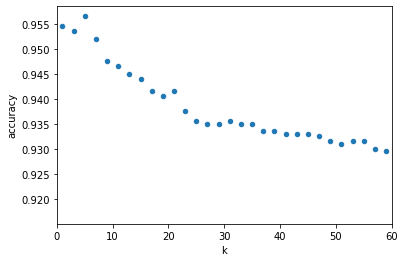

In [13]:
# plot accuracy vs. k
_ = results.plot.scatter(x='k', y='accuracy', xlim=[0, 60])

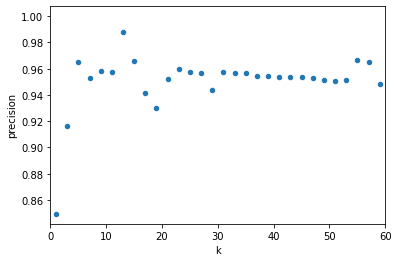

In [14]:
# plot precision vs. k
_ = results.plot.scatter(x='k', y='precision', xlim=[0, 60])

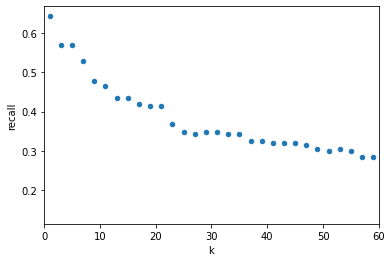

In [15]:
# plot recall vs. k
_ = results.plot.scatter(x='k', y='recall', xlim=[0, 60])

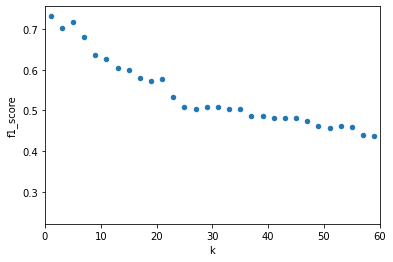

In [16]:
# plot f1 score vs. k
_ = results.plot.scatter(x='k', y='f1_score', xlim=[0, 60])

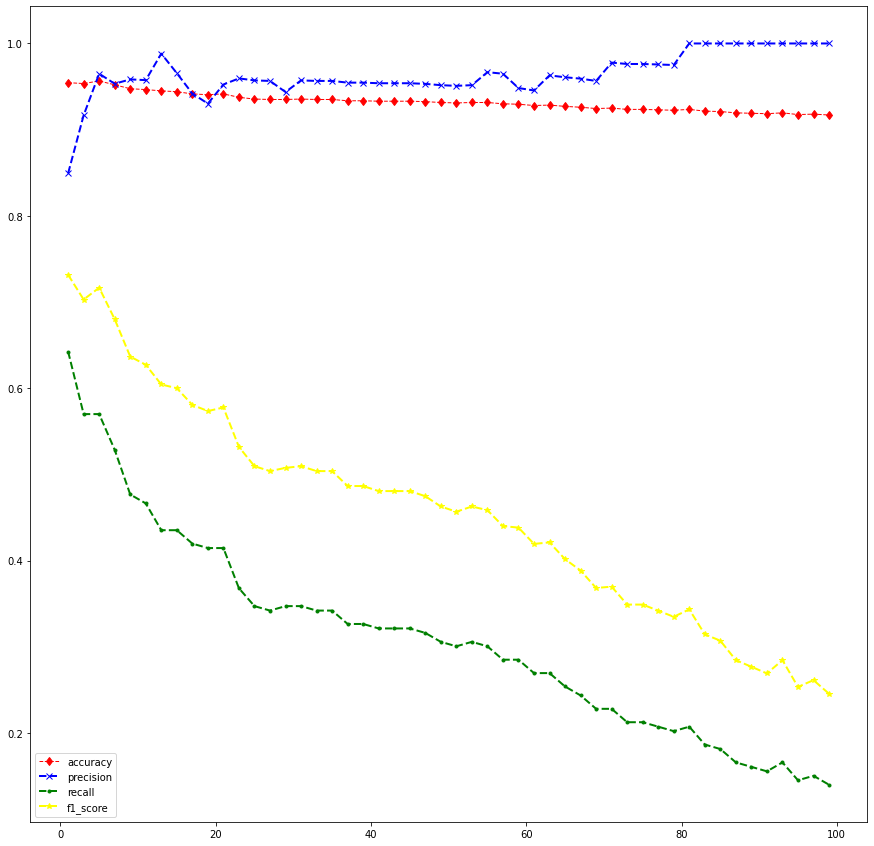

In [17]:
# multiple line plot
from matplotlib import pylab as plt
plt.figure(figsize=(15,15))
plt.plot( 'k', 'accuracy', data=results, marker='d', color='red', linewidth=1, linestyle='dashed', label="accuracy")
plt.plot( 'k', 'precision', data=results, marker='x', color='blue', linewidth=2, linestyle='dashed', label="precision")
plt.plot( 'k', 'recall', data=results, marker='.', color='green', linewidth=2, linestyle='dashed', label="recall")
plt.plot( 'k', 'f1_score', data=results, marker='*', color='yellow', linewidth=2, linestyle='dashed', label="f1_score")
plt.legend()


Let's look at lowest k values that produce the max Precision, max Recall, max accuracy and max f1 score.

In [18]:
# get the index position of max values in every column
maxVals = results.idxmax()
print("*"*10+'accuracy'+'*'*10+"\n", results.iloc[maxVals['accuracy']], "\n")
print("*"*10+'precision'+'*'*10+"\n",results.iloc[maxVals['precision']], "\n")
print("*"*10+'recall'+'*'*10+"\n",results.iloc[maxVals['recall']], "\n")
print("*"*10+'f1_score'+'*'*10+"\n",results.iloc[maxVals['f1_score']], "\n")

**********accuracy**********
 k               5.000000
TP            110.000000
TN           1803.000000
FP              4.000000
FN             83.000000
accuracy        0.956500
error           0.043500
precision       0.964912
recall          0.569948
f1_score        0.716612
Name: 2, dtype: float64 

**********precision**********
 k              81.000000
TP             40.000000
TN           1807.000000
FP              0.000000
FN            153.000000
accuracy        0.923500
error           0.076500
precision       1.000000
recall          0.207254
f1_score        0.343348
Name: 40, dtype: float64 

**********recall**********
 k               1.000000
TP            124.000000
TN           1785.000000
FP             22.000000
FN             69.000000
accuracy        0.954500
error           0.045500
precision       0.849315
recall          0.642487
f1_score        0.731563
Name: 0, dtype: float64 

**********f1_score**********
 k               1.000000
TP            124.000000
TN

## Summary of key measures:

* **Accuracy** is one of the simpler, and most intuitive, measures. It is the total the model got right dived by the total observations.

* **Precision** is more important than **recall** when you would like to have fewer **False Positives** in trade off to have more **False Negatives**. Meaning, getting a **False Positive** is very costly, and a **False Negative** is not as much.

* **Recall** is more important than **precision** when you would like to have less **false negatives** in trade off to have more **False positives**. Meaning, getting a **False negatives** is very costly, and a **False Positive** is not as much. 

* **f1_score** is a measure that represents a balance between **Recall** and **Precision** (represented at a harmonic mean of the two values).

## Conclusion:

Confusion matrix gives you a more complete picture of how our classifiers are performing

You can use the confusion matrix to compute various classification metrics. These metrics can guide your model selection.

Which metrics should you focus on?

* Choice of metric depends on your business objective!
  * There are two types of errors we can make,
    * Identify if FP or FN is more important to reduce:
  * Choose metric with relevant variable (FP or FN in the equation)

    * Example1: Spam filter (positive class is "spam"):
      * Optimize for precision 
        * Precision is more important than recall when you would like to have less False Positives in trade off to have more False Negatives. 
        * Because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter), precision would be a good metric to focus on more heavily.

    * Example2: Medical diagnostics (positive class is "sick"):
      * Optimize for recall
        * Proportion of corrrect positive classifications froms cases that are actually positive. 
        * Because false positives (normal transactions that are flagged as possible sickness) are more acceptable than false negatives (sick patients that are not detected)
  